# Прогнозирование оттока клиентов "Теледом"

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

**Файл `contract_new.csv`**
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

**Файл `personal_new.csv`**
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

**Файл `internet_new.csv`**
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

**Файл `phone_new.csv`**
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

In [1]:
import sklearn # Проверка версии sklearn. Обновляем при необходимости
if sklearn.__version__[0] == '0':
    !pip install scikit-learn==1.5.1 # После установки надо перезапустить ядро
sklearn.__version__ 

'1.5.1'

In [2]:
import pandas as pd
import numpy as np
try:
    import seaborn as sns
except:
    !pip install matplotlib==3.7.3
    import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

try:
    from ydata_profiling import ProfileReport
except:
    !pip install -U Pillow # Для решения ошибки с профайлером
    !pip install -U ydata-profiling
    from ydata_profiling import ProfileReport

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
try:
    from lightgbm import LGBMClassifier
except:
    !pip install lightgbm
    from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

try:
    from optuna.integration import OptunaSearchCV
except:
    !pip install optuna-integration[sklearn]
    from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, CategoricalDistribution

from sklearn.metrics import RocCurveDisplay, accuracy_score, roc_auc_score
try:
    import shap
except:
    !pip install shap
    import shap

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
%matplotlib inline 
RANDOM_STATE=20924 # Константа случайности - дата начала проекта
LOAD_DATE='2020-02-01' # Дата выгрузки данных

## Загрузка, предварительный анализ и предобработка данных

Начнём с загрузки и отдельного представления каждого датасета. Всего их у нас четыре штуки, и чтобы не дублировать конструкции try-except, нужные нам для работы проекта и на сервере и на локальной машине, загрузку будем проводить при помощи функции.

In [4]:
def load(path, dates=None):
    try:
        data = pd.read_csv(path, parse_dates=dates, index_col='customerID')
    except:
        data = pd.read_csv('/'+path, parse_dates=dates, index_col='customerID')
    return data

Начнём с данных о контрактах. Айди клиента - первичный ключ, который имеется у всех наших таблиц, и его мы сразу переведём в индексы.

In [5]:
contract = load('datasets/contract_new.csv', [1])
ProfileReport(contract)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

И так, сразу обратим внимание на наш целевой признак - `EndDate`. Его ещё надо немного преобразовать и выделить в отдельный столбец, но в общем и целом, если значение в нём не равно `no` - значит клиент расторгнул контракт. Это нам и надо научиться угадывать. 

Сами по себе даты не слишком информативны для моделей, однако из них можно будет выделить новый признак - количество дней, в течение которых контракт был активен. 

У `MonthlyCharges` присутствует большое количество экстремально малых значений, но они распределены около значения 20, и их нельзя назвать аномалией. Можно предположить, что где-то там и находится стоимость оказания минимального количества услуг, и многим клиентам нужен только самый минимум.

`TotalCharges` сохранился как текст. К этому мы ещё вернёмся.

Также в данных имеются дубликаты, что вполне возможно, учитывая, что уникальный идентификатор клиента в анализе не учитывался. Не будем обращать на них внимания.

Сразу-же займёмся признаком `TotalCharges`. Что-то препятствует определению его как числового. Найдём, в чём именно проблема. Для этого попробуем выполнить заведемо ошибочную операцию, приготовившись ловить название ошибки.

In [6]:
try:
    pd.to_numeric(contract['TotalCharges'])
except Exception as e:
    print(e)

Unable to parse string " " at position 488


А вот и аномалия. Пробел в 488 строке, хотя их может быть и больше. Заменим пробелы на пропуски и переведем столбец в числовой тип.

In [7]:
contract.loc[contract['TotalCharges']==' ', 'TotalCharges'] = np.nan
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])
contract['TotalCharges'].dtypes

dtype('float64')

Теперь мы сможем посмотреть на распределение значений.

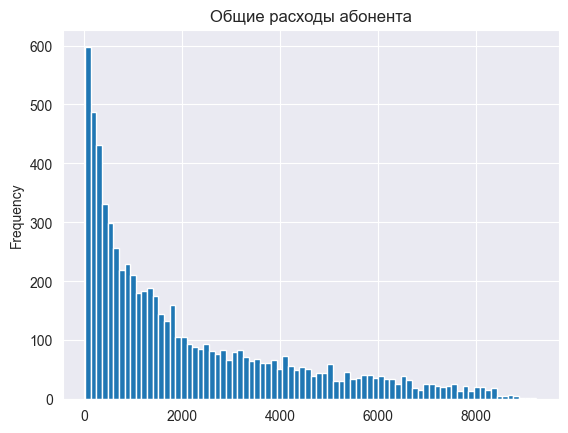

In [8]:
contract['TotalCharges'].plot(kind='hist', bins=80, title='Общие расходы абонента');

Распределение крайне сильно смещено влево, но похоже на правдивое. Далеко не каждый клиент остаётся с компанией надолго и приносит большую прибыль.

Далее загрузим подробные данные о клиентах.

In [9]:
personal = load('datasets/personal_new.csv')
ProfileReport(personal)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Умеренная корреляция наличия партнера и детей. Звучит логично, но до линейной зависимости далеко. В остальном нет ничего, требующего нашего внимания. Данные в отличном состоянии.

Дальше - информация об интернет-услугах.

In [10]:
internet = load('datasets/internet_new.csv')
ProfileReport(internet)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Умеренная корреляция стриминга фильмов и ТВ, в остальном всё стабильно.

И последний датасет - дополнительные телефонные услуги, в котором всего один признак. Не будем его обделять и проведём полноценный EDA.

In [11]:
phone = load('datasets/phone_new.csv')
ProfileReport(phone)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Ни пропусков, ни аномалий. На этом предварительный анализ можно заканчивать и переходить к объединению данных.

**Итого**: Мы провели загрузку всех четырех имеющихся датасетов, провели разведочный анализ, определили перспективы формирования новых признаков, в том числе и целевого признака, а также исправили ошибку определения типа данных столбца `TotalCharges`

## Объединение датасетов и исследовательский анализ

Объединим все датасеты воедино. Для этого используем присоединение по индексу, за основу возьмём датасет `contract` и будем присоединять датасеты один за другим.

In [12]:
ds = contract.join(personal)
ds = ds.join(internet)
ds = ds.join(phone)
ProfileReport(ds)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Возникло много ошибок, но в основном всё связано с двумя факторами - 1) Не все пользуются интернетом или телефонами, и 2) Ежемесячная оплата крайне сильно зависит от подключенных услуг. Разберёмся по порядку. 

21.7% отсутствующих значений в данных по интернету и 9.7% в данных по телефонным линиям. Судя по всему, соответствующее количество клиентов не пользуется интернетом или телефоном, поэтому в датасетах нету информации о них. Можно было-бы просто заполнить пропуски False, т.к. эти клиенты определенно не подключали дополнительных услуг, раз не пользуются даже основными. Однако давайте отдельно отметим тот факт, что они не пользуются основными сервисами.

In [13]:
ds['InternetService'] = ds['InternetService'].fillna('Offline')
for i in internet.columns:
    ds[i] = ds[i].fillna('No')
    print(ds[i].unique())

['DSL' 'Fiber optic' 'Offline']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


То-же самое проделаем для данных о телефонах

In [14]:
ds['MultipleLines'] = ds['MultipleLines'].fillna('Offline')
ds['MultipleLines'].unique()

array(['Offline', 'No', 'Yes'], dtype=object)

Теперь вернёмся к зависимости ежемесячной оплаты. Самая высокая корреляция у неё с типом подключения интернета, проверим так-ли страшна корреляция, как о ней говорят. Заодно, раз-уж мы уже выделили сегмент клиентов, не пользующихся интернетом, отдельно посмотрим и на них.

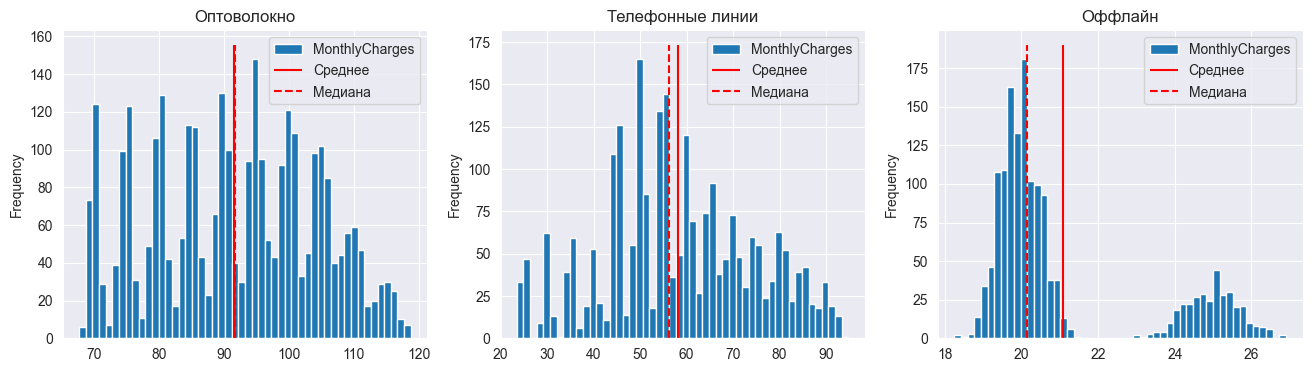

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i in [['Fiber optic','Оптоволокно', 0], ['DSL','Телефонные линии', 1], ['Offline', 'Оффлайн', 2]]:
    ds.loc[ds['InternetService']==i[0], 'MonthlyCharges'].plot(kind='hist', ax=axes[i[2]], title=i[1], bins=50)
    ymin, ymax = axes[i[2]].get_ylim()
    axes[i[2]].vlines(x=ds.loc[ds['InternetService']==i[0], 'MonthlyCharges'].mean(), colors='red', ymin=ymin, ymax=ymax, label='Среднее')
    axes[i[2]].vlines(x=ds.loc[ds['InternetService']==i[0], 'MonthlyCharges'].median(), colors='red', ymin=ymin, ymax=ymax, linestyles='--', label='Медиана')
    axes[i[2]].legend()

Разница разительная. Оптоволокно почти гарантирует высокую абонентскую плату, плата за интернет по телефонным линиям растёт более равномерно, а оффлайн-сегмент как раз и платит за тот самый минимум услуг. Хотя корреляция и высокая, линейной зависимости тут нет. Два одинаковых по абонетской плате клиента могут быть подключены к интернету разными способами. Оставим признак до лучших времён.

Однако до модели мы допустим не все признаки. Например, столбец `gender` никак не соотносится ни с какими другими признаками, поэтому с ним мы попрощаемся.

In [16]:
ds = ds.drop('gender', axis=1)
ds.columns

Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines'],
      dtype='object')

Теперь, когда мы уже находимся на финишной прямой предобработки, удалим пропуски, возникшие в её результате. Это всего 11 записей, те, у которых вместо информации о общей прибыли были пробелы, все остальные пропуски в данных мы уже заполнили полезной информацией.

In [17]:
ds = ds.dropna()
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   EndDate           7032 non-null   object        
 2   Type              7032 non-null   object        
 3   PaperlessBilling  7032 non-null   object        
 4   PaymentMethod     7032 non-null   object        
 5   MonthlyCharges    7032 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   SeniorCitizen     7032 non-null   int64         
 8   Partner           7032 non-null   object        
 9   Dependents        7032 non-null   object        
 10  InternetService   7032 non-null   object        
 11  OnlineSecurity    7032 non-null   object        
 12  OnlineBackup      7032 non-null   object        
 13  DeviceProtection  7032 non-null   object        
 14  TechSupport   

Прежде чем переходить к подготовке данных, выделим целевой признак. Напомню, им у нас является наличие даты в столбце `EndDate`

In [18]:
ds['Terminated'] = ds['EndDate'] != 'No'
ds['Terminated'].value_counts()

Terminated
False    5931
True     1101
Name: count, dtype: int64

Готово. 1 - значит, договор расторгнут, 0 - всё ещё действует на момент выгрузки данных. Соотношение классов почти 6 к 1, дальше не обойтись без стратификации.

**Итого**: Мы провели объединение датасетов, выделили сегменты пользователей, не пользующихся интернетом или телефоном, провели проверку корреляции ежемесячной абонентской платы от типа подключения интернета, избавились от неинформативного признака `gender` и выделили целевой признак `Terminated`.

## Подготовка данных

Начнём с добавления новых признаков. А именно - количество дней активного контракта. Его мы получим, если вычтем из даты окончания контракта(или даты выгрузки данных, если контракт не разорван на момент выгрузки) дату заключения контракта. Сразу после этого признаки `BeginDate` и `EndDate` можно удалить. Сами по себе они не слишком информативны.

In [19]:
ds.loc[ds['EndDate']=='No', 'EndDate'] = LOAD_DATE
ds['EndDate'] = pd.to_datetime(ds['EndDate'])
ds['ActiveDays'] = (ds['EndDate']-ds['BeginDate'])/np.timedelta64(1, 'D')
ds = ds.drop(['BeginDate', 'EndDate'], axis=1)
ds.head(3)

Type PaperlessBilling     PaymentMethod  MonthlyCharges  \
customerID                                                                      
7590-VHVEG  Month-to-month              Yes  Electronic check           29.85   
5575-GNVDE        One year               No      Mailed check           56.95   
3668-QPYBK  Month-to-month              Yes      Mailed check           53.85   

            TotalCharges  SeniorCitizen Partner Dependents InternetService  \
customerID                                                                   
7590-VHVEG         31.04              0     Yes         No             DSL   
5575-GNVDE       2071.84              0      No         No             DSL   
3668-QPYBK        226.17              0      No         No             DSL   

           OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
customerID                                                            
7590-VHVEG             No          Yes               No          No   
5575-GNVDE            Yes           No              Yes          No   
3668-QPYBK            Yes          Yes               No          No   

           StreamingTV StreamingMovies MultipleLines  Terminated  ActiveDays  
customerID                                                                    
7590-VHVEG          No              No       Offline       False        31.0  
5575-GNVDE          No              No            No       False      1036.0  
3668-QPYBK          No              No            No       False       123.0

Прежде чем переходить к препроцессингу, раз-уж у нас уже имеются все необходимые параметры, проследим за наглядными зависимости, какие клиенты более склонны к уходу.

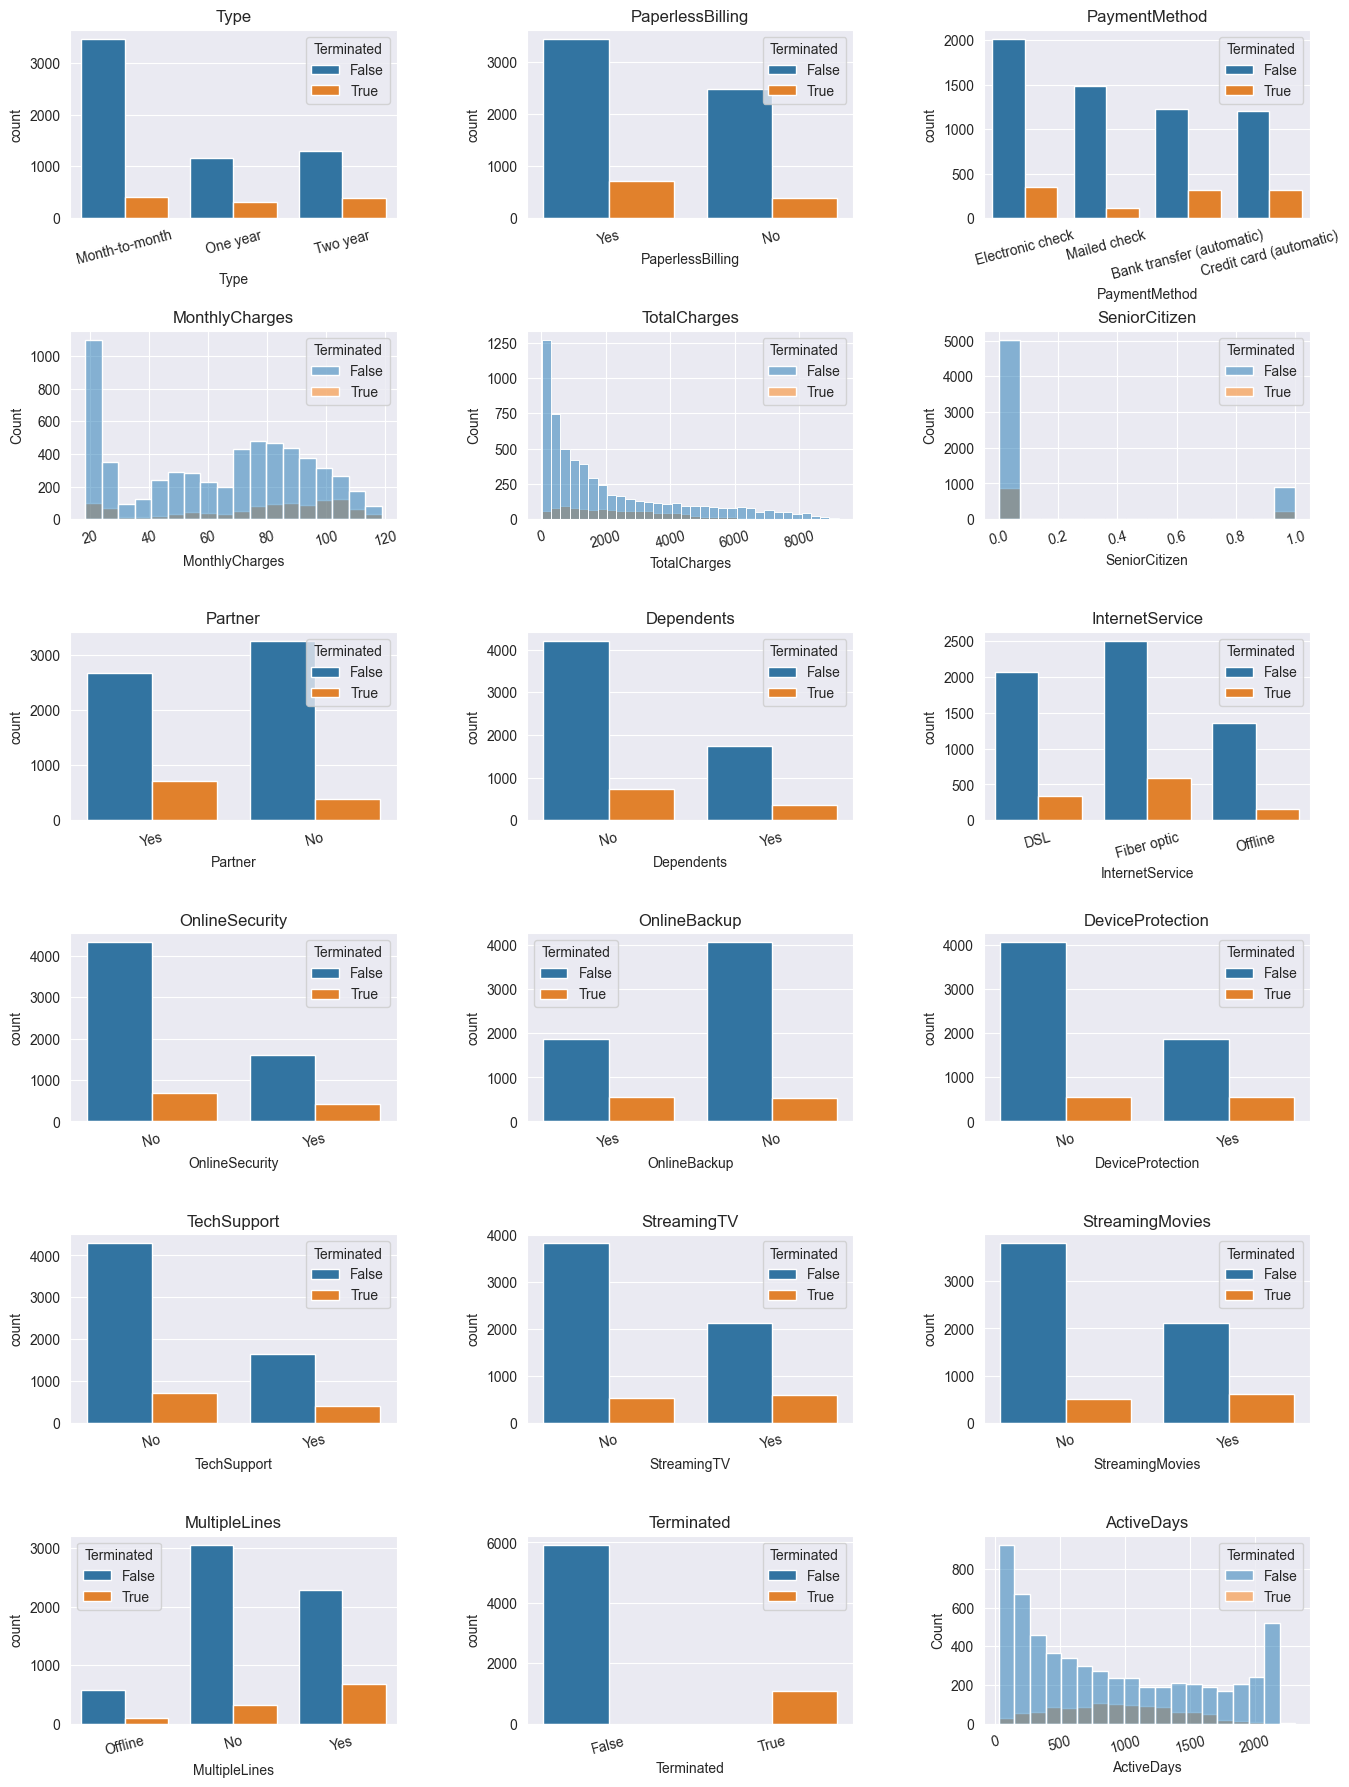

In [20]:
fig, axes = plt.subplots(6, 3, figsize=(16, 22))

for j, i in enumerate(ds.columns):
    if ds[i].dtypes in ['bool', 'O']:
        sns.countplot(ds[i], hue=ds['Terminated'], ax=axes[j//3, j%3])
    else:
        sns.histplot(ds, x=i, hue='Terminated', ax=axes[j//3, j%3])
    axes[j//3, j%3].set_title(i)
    axes[j//3, j%3].tick_params(axis='x', rotation=15)
    plt.subplots_adjust(hspace=0.6, wspace=0.4)

И так, у нас есть более подробное представление о том, кто больше склонен к тому, чтобы расторгнуть контракт. Например, клиенты с партнёром более склонны к уходу, чем без него, а большая часть ушедших клиентов провела с компанией от 500 до 1500 дней.

Теперь разделим данные на выборки. Последующая обработка может привести к утечке целевого признака, если мы продолжим работать с полным датасетом. Тестовую выборку отложим до конца работы, до неё мы допустим только самую лучшую модель.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    ds.drop('Terminated', axis=1),
    ds['Terminated'],
    random_state=RANDOM_STATE,
    stratify=ds['Terminated'],
    test_size=.25
)

Теперь займёмся препроцессингом. Он предполагает кодировку нечисловых значений. Для удобства разделим категориальные признаки на две группы - бинарные и небинарные. Для каждой из групп будут использоваться лучше подходящие конкретно для них кодировщики. Обработку признаков будем проводить в пайплайне. Так удобнее, да и при необходимости обучить модель на новом наборе данных потребуется меньше телодвижений.

In [22]:
ohe_columns = ['StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection', 'OnlineBackup', 'Dependents', 'Partner', 'PaperlessBilling', 'OnlineSecurity']
ordinal_columns = ['MultipleLines', 'InternetService', 'PaymentMethod', 'Type']

ohe_pipe = Pipeline([
    ('encode', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    ('impute', SimpleImputer(strategy='most_frequent'))
])
ordinal_pipe = Pipeline([
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('impute', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ordinal', ordinal_pipe, ordinal_columns)
],
remainder='passthrough'
)

**Итого**: Мы сгенерировали новый признак `ActiveDays`из имеющихся данных, удалили неинформативные признаки и подготовили пайплайны препроцессинга для будущих моделей.

## Обучение моделей

Теперь самое интересное - при помощи средств МО нам необходимо минимизировать убытки компании. Ложно-положительные ответы(промокод выдан пользователю, не собирающемуся уходить) и ложно-отрицательные ответы(промокод не выдан нужному пользователю, из-за чего он ушёл) в равной степени вредны для компании. А потому в качестве метрики мы будем использовать площадь под roc-кривой, или `roc-auc`. Эта метрика учитывает оба типа ошибок в равной степени, и не привязана к порогам классификации. Её мы будем использовать при обучении, но также будем регулярно посматривать и на `accuracy`, отношение верных ответов к общему числу ответов модели.

Критерий успеха - roc-auc не меньше 0.85

In [23]:
def model_presentation(model, X, y, isittest=False): # Функция для презентации результатов работы моделей
    if not isittest: # На тренировочных данных проводится кросс валидация, для тестовых просто вычисляются метрики
        print('Cross-val roc-auc: '+str((cross_val_score(model, X, y, scoring='roc_auc', cv=StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)).mean()*100).round(1))+'%')
        print('Cross-val accuracy: '+str((cross_val_score(model, X, y, scoring='accuracy', cv=StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)).mean()*100).round(1))+'%')
    else:
        print('Roc-auc: '+str(np.round(roc_auc_score(y, model.predict_proba(X)[:, 1])*100))+'%')
        print('Accuracy: '+str(np.round(accuracy_score(y, model.predict(X))*100, 1))+'%')
    RocCurveDisplay.from_estimator(model, X, y)
    plt.title(str(model.named_steps['model']))

Первой обучим классическую модель к-ближайших соседей. При обучении будем перебирать гиперпараметры при помощи OptunaSearchCV, а проверять качество будем с помощью стратифицированной кросс-валидации.

C:\Users\m8913\AppData\Local\Temp\ipykernel_67964\3985853747.py:11: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  svm_cv = OptunaSearchCV(
[I 2024-09-05 09:33:55,509] A new study created in memory with name: no-name-f135cca5-26d0-48c1-aab3-c3728d5b4027
[I 2024-09-05 09:33:56,092] Trial 0 finished with value: 0.7413696445056986 and parameters: {'model__n_neighbors': 62, 'model__p': 2}. Best is trial 0 with value: 0.7413696445056986.
[I 2024-09-05 09:33:56,413] Trial 1 finished with value: 0.7445034828668495 and parameters: {'model__n_neighbors': 64, 'model__p': 1}. Best is trial 1 with value: 0.7445034828668495.
[I 2024-09-05 09:33:56,880] Trial 2 finished with value: 0.7447131683210089 and parameters: {'model__n_neighbors': 60, 'model__p': 1}. Best is trial 2 with value: 0.7447131683210089.
[I 2024-09-05 09:33:57,347] Trial 3 finished with value: 0.7409379055567646 and parameters: {'model__n_neighbors': 76, 'mode

Cross-val roc-auc: 74.5%
Cross-val accuracy: 84.2%


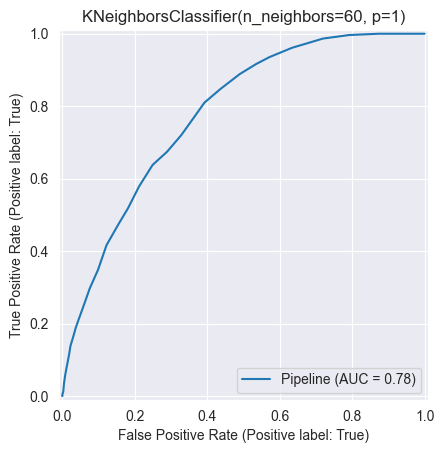

In [24]:
svm = Pipeline([
    ('preprocessing', preprocessor),
    ('model', KNeighborsClassifier())
])

svm_params = {
    'model__n_neighbors':IntDistribution(30, 80),
    'model__p':CategoricalDistribution([1, 2])
}

svm_cv = OptunaSearchCV(
    svm,
    param_distributions=svm_params,
    cv=StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True),
    random_state=RANDOM_STATE,
    n_trials=5,
    scoring='roc_auc'
)

svm_cv.fit(X_train, y_train)
model_presentation(svm_cv.best_estimator_, X_train, y_train)

Результат не самый лучший, хотя всё ещё достойный. Посмотрим, получится-ли у нас побить этот рекорд. Следующей моделью рассмотрим случайный лес.

C:\Users\m8913\AppData\Local\Temp\ipykernel_67964\3006302124.py:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  forest_cv = OptunaSearchCV(
[I 2024-09-05 09:33:58,865] A new study created in memory with name: no-name-a2e46021-d85d-47b8-865c-31efeceb9994
[I 2024-09-05 09:34:00,316] Trial 0 finished with value: 0.8148616482749889 and parameters: {'model__n_estimators': 164, 'model__min_samples_split': 106, 'model__min_samples_leaf': 87}. Best is trial 0 with value: 0.8148616482749889.
[I 2024-09-05 09:34:01,787] Trial 1 finished with value: 0.818029068680185 and parameters: {'model__n_estimators': 168, 'model__min_samples_split': 109, 'model__min_samples_leaf': 66}. Best is trial 1 with value: 0.818029068680185.
[I 2024-09-05 09:34:03,240] Trial 2 finished with value: 0.8199875315959627 and parameters: {'model__n_estimators': 161, 'model__min_samples_split': 123, 'model__min_samples_leaf': 50}. Best is trial 2 wi

Cross-val roc-auc: 82.0%
Cross-val accuracy: 85.0%


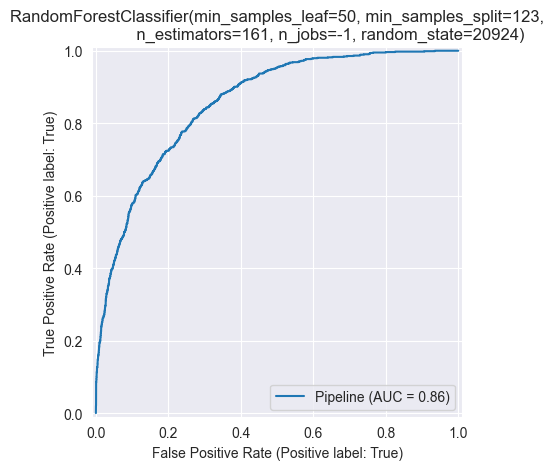

In [25]:
forest = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

forest_params = {
    'model__n_estimators':IntDistribution(100, 200),
    'model__min_samples_split':IntDistribution(80, 150),
    'model__min_samples_leaf':IntDistribution(50, 100)
}

forest_cv = OptunaSearchCV(
    forest,
    param_distributions=forest_params,
    cv=StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True),
    random_state=RANDOM_STATE,
    n_trials=5,
    scoring='roc_auc'
)

forest_cv.fit(X_train, y_train)
model_presentation(forest_cv.best_estimator_, X_train, y_train)

Качество заметно выше, но всё-же не дотягивает до критерия успеха совсем немного. Самое время попробовать более сложную модель. Но для этого придётся немного изменить обычный препроцессинг. Создадим класс для назначения типа категориальным данным, чтобы не делать это вручную. 

In [26]:
class FeaturesToCats(TransformerMixin, BaseEstimator): # Класс для преобразования признаков в пайплайне
    def __init__(self): 
        return None
    def fit(self, X, y): # Обучение классу не требуется, скипаем
        return self
    
    def transform(self, X): # Категориальным признакам присваивается соответствующий тип данных
        dc = X.copy()
        dc[dc.select_dtypes(exclude='number').columns] = dc[dc.select_dtypes(exclude='number').columns].astype('category')
        return dc

Это требуется для того, чтобы модель лёгкого градиентного бустинга смогла работать с категориями напрямую. Именно её мы и обучим следующей.

C:\Users\m8913\AppData\Local\Temp\ipykernel_67964\771591730.py:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  gradient_cv = OptunaSearchCV(
[I 2024-09-05 09:34:09,719] A new study created in memory with name: no-name-b88a34a8-0dec-4e0f-ba4d-59d798bdc919
[I 2024-09-05 09:34:12,033] Trial 0 finished with value: 0.8646754800056012 and parameters: {'model__num_leaves': 23, 'model__min_child_samples': 5, 'model__n_estimators': 420}. Best is trial 0 with value: 0.8646754800056012.
[I 2024-09-05 09:34:14,027] Trial 1 finished with value: 0.8553170932949625 and parameters: {'model__num_leaves': 24, 'model__min_child_samples': 5, 'model__n_estimators': 298}. Best is trial 0 with value: 0.8646754800056012.
[I 2024-09-05 09:34:15,468] Trial 2 finished with value: 0.8422784110402091 and parameters: {'model__num_leaves': 22, 'model__min_child_samples': 7, 'model__n_estimators': 200}. Best is trial 0 with value: 0.864675480

Cross-val roc-auc: 86.5%
Cross-val accuracy: 88.0%


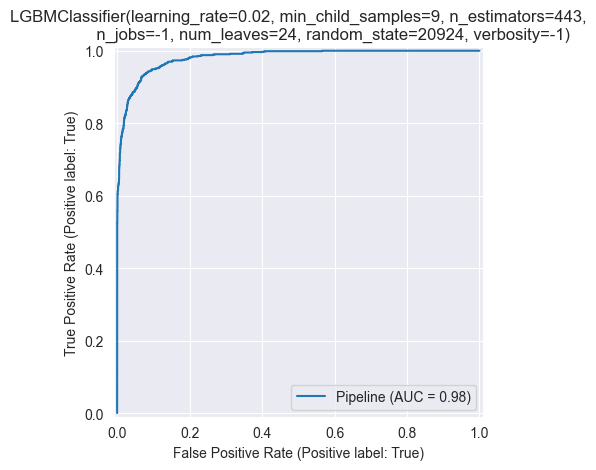

In [27]:
gradient = Pipeline([
    ('transformer', FeaturesToCats()),
    ('model', LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, learning_rate=.02, verbosity=-1))
])

gradient_params = {
    'model__num_leaves':IntDistribution(10, 30),
    'model__min_child_samples':IntDistribution(2, 10),
    'model__n_estimators':IntDistribution(200, 500)
    
}

gradient_cv = OptunaSearchCV(
    gradient,
    param_distributions=gradient_params,
    cv=StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True),
    random_state=RANDOM_STATE,
    n_trials=5,
    scoring='roc_auc'
)

gradient_cv.fit(X_train, y_train)
model_presentation(gradient_cv.best_estimator_, X_train, y_train)

А вот и тот результат, которого мы ждали. Хоть график roc-кривой и рисует нам подозрительно позитивную картину, значения метрики на кросс-валидации действительно проходят по критериям успеха. Вот и наша лучшая модель - `LGBMClassifier`

**Итого**: Мы обучили 3 модели-классификатора - к-ближайших соседей, случайный лес и лёгкий градиентный бустинг, добились требуемого значения метрики на кросс-валидации, и выбрали лучшую модель.

## Тестирование лучшей модели

Но прежде, чем мы приступим к тестированию, создадим модель-болванку, над результатами которой мы будем потешаться, нахваливая лучшую модель. Ну и, конечно, проверим лучшую модель на адекватность.

Roc-auc: 50.0%
Accuracy: 84.4%


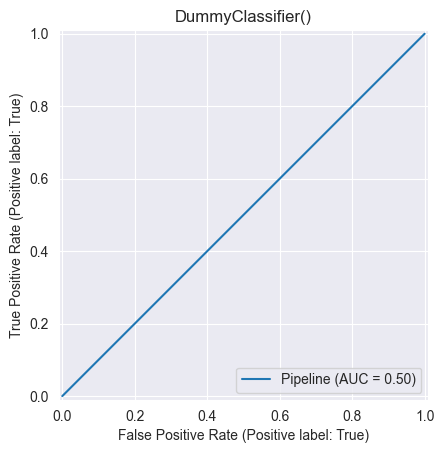

In [28]:
dummy = Pipeline([
    ('preprocessing', preprocessor),
    ('model', DummyClassifier())
])
dummy.fit(X_train, y_train)
model_presentation(dummy, X_test, y_test, True)

А вот и наша roc-прямая, ибо кривой её не назовёшь. Значение accuracy оптимистично показывает почти идеальное значение качества, даже не подозревая, как заблуждается. Дисбаланс классов оставляет свой отпечаток.

А теперь перейдём к финальному тестированию. Для этого обучим модель с лучшими параметрами на всех тренировочных данных, а после отправим на вычисление нужных метрик вместе с тестовыми данными.

Roc-auc: 90.0%
Accuracy: 88.9%


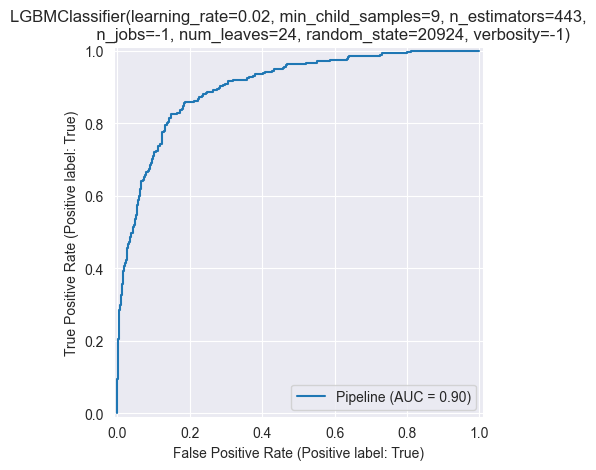

In [29]:
gradient_cv.best_estimator_.fit(X_train, y_train)
model_presentation(gradient_cv.best_estimator_, X_test, y_test, True)

А вот и метрики. Accuracy лишь немного превышает показатель модели-болванки, но Roc-auc выше требуемого значения, а это значит, что на этом наша работа заканчивается.

**Итого**: Мы обучили модель болванку и модель лёгкого градиентного бустинга с лучшими гиперпараметрами на всей тренировочной выборке и сравнили метрики на тестовых данных. Модель прошла проверку на адекватность и готова к работе.

## Итоговый вывод и рекомендации

В рамках **предобработки**, мы:
- Провели загрузку и предварительный анализ изначальных данных;
- Исправили ошибки выгрузки данных.

В рамках **исследовательского анализа**, мы:
- Провели объединение датасетов и общий EDA;
- Заполнили пропуски в информации об использовании телефонов и интернета;
- Исследовали зависимость ежемесячной оплаты от типа подключений интернета;
- Избавились от неинформативных признаков;
- Сформировали из имеющихся данных целевой признак.

В рамках **подготовки данных**, мы:
- Сформировали новый признак `ActiveDays` из имеющихся признаков;
- Провели подробный анализ зависимости целевого признака от входных;
- Провели разделение данных на выборки;
- Создали пайплайны для будущего препроцессинга.

В рамках **обучения моделей**, мы:
- Сформировали пайплайны и сетки параметров для моделей;
- Создали объекты OptunaSearchCV для подбора гиперпараметров с оценкой качества при помощи стратифицированной кросс-валидации;
- Последовательно запустили обучение моделей `KNeighborsClassifier`, `RandomForestClassifier` и `LGBMClassifier`;
- Опредилили лучшую модель на основе оценки качества на кросс-валидации.

В рамках **финального тестирования**, мы:
- Обучили классификатор-болванку для проверки лучшей модели на адекватность;
- Обучили лучшую модель на всей тренировочной выборке и расчитали метрики на тестовых данных.